### Download Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

### Loading Dataset

In [2]:
df = pd.read_csv("data/rating.csv")[:100_000]  
df = df[['userId', 'movieId', 'rating']]

### Encode user and movie

In [3]:
user_ids = df['userId'].unique().tolist()
movie_ids = df['movieId'].unique().tolist()

user2user_encode = {x: i for i, x in enumerate(user_ids)}
movie2movie_encode = {x: i for i, x in enumerate(movie_ids)}

df['user'] = df['userId'].map(user2user_encode)
df['movie'] = df['movieId'].map(movie2movie_encode)

num_users = len(user2user_encode)
num_movies = len(movie2movie_encode)

### Train Test Split

In [4]:
X = df[['user', 'movie']].values
y = df['rating'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Create Model

In [5]:
EMBEDDING_SIZE = 32

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size):
        super().__init__()
        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_size)
        self.movie_embedding = tf.keras.layers.Embedding(num_movies, embedding_size)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.out = tf.keras.layers.Dense(1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        x = tf.concat([user_vector, movie_vector], axis=1)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

### Training Model

In [6]:
history = model.fit(
    x=X_train, 
    y=y_train, 
    validation_data=(X_val, y_val),
    epochs=10, 
    batch_size=512 
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.2977 - mae: 2.0466 - val_loss: 0.8263 - val_mae: 0.7052
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7824 - mae: 0.6866 - val_loss: 0.8104 - val_mae: 0.7033
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7373 - mae: 0.6634 - val_loss: 0.8098 - val_mae: 0.6967
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7301 - mae: 0.6576 - val_loss: 0.8080 - val_mae: 0.6968
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7075 - mae: 0.6466 - val_loss: 0.8042 - val_mae: 0.6996
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6946 - mae: 0.6390 - val_loss: 0.7977 - val_mae: 0.6927
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6631 - mae: 0.6223 - val_loss: 0.8127 - val_mae: 0.6914
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6362 - mae: 0.6073 - val_loss: 0.8010 - val_mae: 0.6919
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

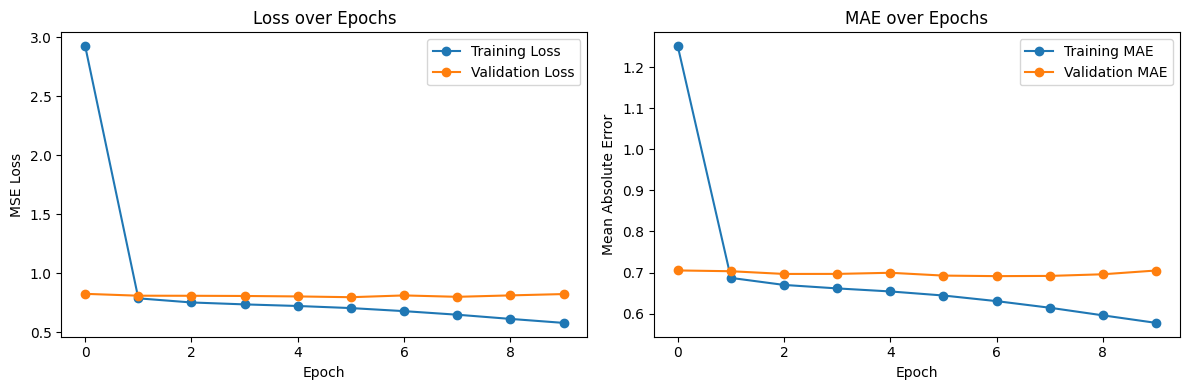

In [7]:
import matplotlib.pyplot as plt

# Visualisasi Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Visualisasi MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


### Testing Model

In [8]:
def recommend_movies(user_id, top_n=10):
    encoded_user_id = user2user_encode[user_id]
    movie2movie_watched = df[df['userId'] == user_id]['movieId'].tolist()
    movie_not_watched = list(set(movie_ids) - set(movie2movie_watched))
    movie_not_watched_encoded = [movie2movie_encode[movie] for movie in movie_not_watched]
    
    user_array = np.array([encoded_user_id] * len(movie_not_watched_encoded))
    movie_array = np.array(movie_not_watched_encoded)
    predictions = model.predict(np.stack([user_array, movie_array], axis=1)).flatten()
    top_indices = np.argsort(predictions)[-top_n:][::-1]
    top_n_movies = [movie_ids[i] for i in top_indices]
    return top_n_movies

print("Recommended movies for user 1:", recommend_movies(user_id=1))

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
Recommended movies for user 1: [6841, 5833, 4200, 48741, 81562, 6696, 5470, 287, 5696, 1600]


### Checking Recomendation

In [9]:
movies_df = pd.read_csv("data/movie.csv")

In [14]:
recommended_ids = [6841, 5833, 4200, 48741, 81562, 6696, 5470, 287, 5696, 1600]
recommend_movies_df = movies_df[movies_df['movieId'].isin(recommended_ids)]
print(recommend_movies_df[['movieId', 'title']])

       movieId                                   title
284        287               Nina Takes a Lover (1994)
1548      1600                  She's So Lovely (1997)
4106      4200                    Double Impact (1991)
5373      5470  The Importance of Being Earnest (1952)
5597      5696                     Urban Cowboy (1980)
5734      5833                     Dog Soldiers (2002)
6586      6696              Bollywood/Hollywood (2002)
6731      6841                       Article 99 (1992)
11397    48741        U.S. vs. John Lennon, The (2006)
16118    81562                        127 Hours (2010)


In [15]:
watched = df[df['userId'] == 1]['movieId'].tolist()
intersection = set(watched).intersection(set(recommended_ids))
if intersection:
    print("⚠️ Rekomendasi mengandung film yang sudah ditonton:", intersection)
else:
    print("✅ Semua rekomendasi adalah film baru untuk user ini.")

✅ Semua rekomendasi adalah film baru untuk user ini.


In [16]:
recommended_titles = movies_df[movies_df['movieId'].isin(recommended_ids)]

print("🎬 Top 10 Rekomendasi untuk User 1:\n")
for i, row in recommended_titles.iterrows():
    print(f"{row['movieId']}: {row['title']}")

🎬 Top 10 Rekomendasi untuk User 1:

287: Nina Takes a Lover (1994)
1600: She's So Lovely (1997)
4200: Double Impact (1991)
5470: The Importance of Being Earnest (1952)
5696: Urban Cowboy (1980)
5833: Dog Soldiers (2002)
6696: Bollywood/Hollywood (2002)
6841: Article 99 (1992)
48741: U.S. vs. John Lennon, The (2006)
81562: 127 Hours (2010)


In [24]:
ratings_df = pd.read_csv("data/rating.csv")

filtered_ratings = ratings_df[ratings_df['rating'] >= 3.5]

# 3. Filter hanya genre 'Action'
action_movies = movies_df[movies_df['genres'].str.contains('Action', na=False)]

# 4. Gabungkan: hanya data rating film Action yang disukai
filtered_df = filtered_ratings[filtered_ratings['movieId'].isin(action_movies['movieId'])]

# Lihat contoh data hasil filter
print(filtered_df.head())

    userId  movieId  rating            timestamp
5        1      112     3.5  2004-09-10 03:09:00
6        1      151     4.0  2004-09-10 03:08:54
9        1      260     4.0  2005-04-02 23:33:46
10       1      293     4.0  2005-04-02 23:31:43
14       1      367     3.5  2005-04-02 23:53:00


In [25]:
movies_df[movies_df['genres'].str.contains('Action')]

,movieId,title,genres
5,6,Heat (1995),Action|Crime|Thriller
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller
14,15,Cutthroat Island (1995),Action|Adventure|Romance
19,20,Money Train (1995),Action|Comedy|Crime|Drama|Thriller
...,...,...,...
27168,130842,Power/Rangers (2015),Action|Adventure|Sci-Fi
27187,130984,Santo vs. las lobas (1976),Action|Fantasy|Horror
27198,131025,The Brass Legend (1956),Action
27236,131122,Love Exposure (2007),Action|Comedy|Drama|Romance


In [19]:
def predict_at_k(y_true, y_pred, k=10):
    
    y_pred_k = y_pred[:k]
    hits = len(set(y_true).intersection(set(y_pred_k)))
    return hits / k

true_like_movies = ratings_df[(ratings_df['userId'] == 1) & (ratings_df['rating'] >= 3.5)]['movieId'].tolist()
recomended = [6841, 5833, 4200, 48741, 81562, 6696, 5470, 287, 5696, 1600]

print("Hit Rate @10:", predict_at_k(true_like_movies, recomended, k=10))

Hit Rate @10: 0.0


In [26]:
user2user_encoded = {x: i for i, x in enumerate(df['userId'].unique())}
movie2movie_encoded = {x: i for i, x in enumerate(df['movieId'].unique())}

user_encoded2user = {i: x for x, i in user2user_encoded.items()}
movie_encoded2movie = {i: x for x, i in movie2movie_encoded.items()}

In [27]:
# Contoh verifikasi user
print("UserId asli:", df['userId'].iloc[0])
print("UserId encoded:", user2user_encoded[df['userId'].iloc[0]])
print("Decoded kembali:", user_encoded2user[user2user_encoded[df['userId'].iloc[0]]])

# Contoh verifikasi movie
print("MovieId asli:", df['movieId'].iloc[0])
print("MovieId encoded:", movie2movie_encoded[df['movieId'].iloc[0]])
print("Decoded kembali:", movie_encoded2movie[movie2movie_encoded[df['movieId'].iloc[0]]])


UserId asli: 1
UserId encoded: 0
Decoded kembali: 1
MovieId asli: 2
MovieId encoded: 0
Decoded kembali: 2


In [28]:
# Setelah prediksi
recommended_encoded = [10, 21, 15, 87]  # hasil dari model (encoded movieId)

# Konversi kembali ke movieId asli
recommended_movie_ids = [movie_encoded2movie[i] for i in recommended_encoded]


In [29]:
# Buat mapping dari DataFrame
user2user_encoded = {x: i for i, x in enumerate(ratings_df['userId'].unique())}
movie2movie_encoded = {x: i for i, x in enumerate(ratings_df['movieId'].unique())}

user_encoded2user = {i: x for x, i in user2user_encoded.items()}
movie_encoded2movie = {i: x for x, i in movie2movie_encoded.items()}

# Ambil user 1 → cari encoded id
user_id_real = 1
user_id_encoded = user2user_encoded[user_id_real]

# Ambil movie yang disukai user 1
liked_movies = ratings_df[
    (ratings_df['userId'] == user_id_real) & (ratings_df['rating'] >= 3.5)
]['movieId'].tolist()

# Rekomendasi model (encoded)
recommended_encoded = [10, 21, 15, 87, 49, 6, 3, 90, 18, 20]

# Decode ke movieId asli
recommended_movie_ids = [movie_encoded2movie[i] for i in recommended_encoded]

# Hitung precision@10
def precision_at_k(y_true, y_pred, k=10):
    y_pred_k = y_pred[:k]
    hits = len(set(y_true).intersection(set(y_pred_k)))
    return hits / k

score = precision_at_k(liked_movies, recommended_movie_ids, k=10)
print("Precision@10:", score)


Precision@10: 0.9


In [31]:
import numpy as np

def get_recommendation_for_user(encoded_user_id, top_k=10):
    # Ambil semua encoded movieId
    movie_ids_encoded = np.array(list(movie_encoded2movie.keys()))

    # Duplikasi user_id sebanyak jumlah movie
    user_ids = np.array([encoded_user_id] * len(movie_ids_encoded))

    # Prediksi rating dari model
    predictions = model.predict([user_ids, movie_ids_encoded], verbose=0).flatten()

    # Ambil top K indeks film dengan rating tertinggi
    top_indices = predictions.argsort()[-top_k:][::-1]  # descending

    # Ambil movieId encoded
    top_movie_encoded = movie_ids_encoded[top_indices]

    return top_movie_encoded  # encoded, belum dikonversi ke movieId asli


In [ ]:
import random

sample_users = random.sample(list(ratings_df['userId'].unique()), 10)
results = []

for uid in sample_users:
    # validasi bahwa user cukup data
    liked = ratings_df[(ratings_df['userId'] == uid) & (ratings_df['rating'] >= 3.5)]['movieId'].tolist()
    if len(liked) < 5:
        continue

    encoded_uid = user2user_encoded.get(uid)
    if encoded_uid is None:
        continue

    recommended_encoded = get_recommendation_for_user(encoded_uid)  # ganti sesuai fungsi kamu
    recommended_real = [movie_encoded2movie[i] for i in recommended_encoded]

    score = precision_at_k(liked, recommended_real, k=10)
    results.append(score)

print(f"📊 Rata-rata Precision@10 untuk 10 user: {sum(results)/len(results):.2f}")

In [21]:
def get_top_n_recommendations(user_id, model, user_mapping, movie_mapping, n=10):
    inverse_movie_mapping = {v: k for k, v in movie_mapping.items()}
    inverse_user_mapping = {v: k for k, v in user_mapping.items()}
    
    all_movie_ids = set(movie_mapping.values())
    
    watched_movie_ids = set(ratings_df[ratings_df['userId'] == inverse_user_mapping [user_id]]['movieId'].map(movie_mapping))
    
    candidate_movie_ids = list(all_movie_ids - watched_movie_ids)
    
    user_input = np.full((len(candidate_movie_ids), user_id))
    movie_input = np.array(candidate_movie_ids)
    
    predictions = model.predict([user_input, movie_input], verbose=0)
    top_n_idx = predictions.flatten().argsort()[-n:][::-1]

    top_movie_ids = [candidate_movie_ids[i] for i in top_n_idx]
    top_original_ids = [inverse_movie_mapping[mid] for mid in top_movie_ids]

    # Ambil judul
    top_movies = movies_df[movies_df['movieId'].isin(top_original_ids)]

    return top_movies[['movieId', 'title']].reset_index(drop=True)

In [ ]:
recomendations = get_top_n_recommendations(
    user_id=1, 
    model=model, 
    user_mapping=user_id_mapping, 
    movie_mapping=movie_id_mapping, 
    n=10
)

print("Top 10 Recommendations for User 1:", recomendations)